# Analysing trends in KeyForge sales using PyMC3

The collectible card game KeyForge from Fantasy Flight Games is unique in many ways. I highly recommend checking it out if you have an interest in card and board games. In a nutshell, what matters here is that cards are sold only as complete decks, randomly generate so each deck is unique. Each deck comes with a QR code that can be scanned using a companion app to register the deck online. This is a requirement for competitive players though it also has an advantage for casual players as it yields points that can be redeemed for physical prices, is an easy way to keep track of your collection, ... For us this is good news as that the number of registered decks appear on the main website in real time. As such, tracking how many decks are registered over time is a very good proxy for the number of decks actually sold.

Since KeyForge's release in November 2018, new sets have been released every 6-8 months, which are usually preceeded by active advertising campaigns. So the release of each new set is expected to rekindle interest in the game, though different sets are received with different levels of enthousiasm, so this is one of the factors that will impact sales.

Furtermore, about 1.5 years after the initial release, COVID-19 measures forced game shops to close or at least were no longer able to host players and tournaments. Given this game has no online version, the lack of options to play in the real world will likely affect sales negatively.

In this notebook we'll try to model both the overal number of registered decks using a Bayesian model, starting from a humble linear model and adding in additional effects, like the COVID-19 restrictions starting and new sets, with different popularities, being released.


## Data Source

Data included in this analysis was provided by Duk from [Archon Arcana](https://archonarcana.com/) and includes the total number of registered decks per week since the release of KeyForge. Furthermore, by scraping the deck page from the [KeyForge Master Vault](https://www.keyforgegame.com/explore) they can even provide stats on which sets the newly registered decks are from. For now we only need the week since release and the number of registered decks.

## Installing everything

On windows you need Visual Studio Code Build Tools 2017 and the C tools (check components during installation, this is not included by default), the environment.yml can be used to create a conda env that contain everything.


In [1]:
%load_ext nb_black

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import altair as alt
import json

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

We use pandas to load the data. There is very little need for processing the data, though the first datapoint was taken after 3 days, while every other point is taken weekly on Sunday. So we'll exclude this first point, we'll also scale the number of registered decks down as some models don't like very large numbers. 

In [2]:
data = pd.read_csv('./data/archon_arcana_weekly_20210619.csv', thousands=',')
data['Week_nr'] = data.index
data = data[data.Week_nr > 0] # ignore first line which is day 3, start with week 1
model_data = data[["Week_nr", "Total"]].copy()
model_data["Total_scaled"] = model_data["Total"]/10000 # PyMC3 doesn't seem to like very large numbers, so lets bring them down a few orders of magnitude
model_data


,Week_nr,Total,Total_scaled
1,1,158016,15.8016
2,2,218733,21.8733
3,3,268026,26.8026
4,4,311895,31.1895
5,5,358098,35.8098
...,...,...,...
130,130,2308213,230.8213
131,131,2332833,233.2833
132,132,2346868,234.6868
133,133,2359112,235.9112


<IPython.core.display.Javascript object>

To start, lets plot the raw data.

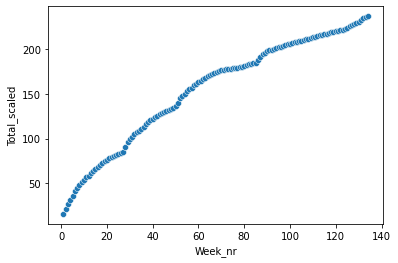

<IPython.core.display.Javascript object>

In [3]:
sns.scatterplot(data=model_data, x="Week_nr", y="Total_scaled")
plt.show()

## A humble beginning - Fitting a linear model

Just to start let's fit a simple linear model onto this curve. This will make sure everything is working as it should and give us some initial impression of the data. The equation is

y = ax + b

where x would be the weeks since release, and y the number of registered decks. The slope *a* would be the number of decks registered per week. As on point zero there would not have been any decks sold, we don't need an intercept (b), we only have a single variable in the model, the slope. 

For Bayesian models we do need to include some priors, we have to provide the model with some sensible values to start, which will be refined during sampling. In case we have prior knowledge we can incorporate this at this stage. However here we'll assume, like Jon Snow, we know nothing and we'll set our priors to very generic value with a large uncertainty.

In [4]:
with pm.Model() as model:
    # priors
    sigma = pm.Exponential("sigma", lam=1.0)
    slope = pm.Normal("slope", mu=0, sigma=20)

    # Likelihood
    likelihood = pm.Normal(
        "y",
        mu=slope * model_data.Week_nr,
        sigma=sigma,
        observed=model_data.Total_scaled,
    )

    # posterior
    trace = pm.sample(1000, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

Before looking at the fit we can also check some of the potiential outcomes of the model based on the priors alone. This can highlight issues with the model, ... and there are many. (We could also do this prior to running the sampling to pick up issues before wasting CPU cycles fitting a poor model)

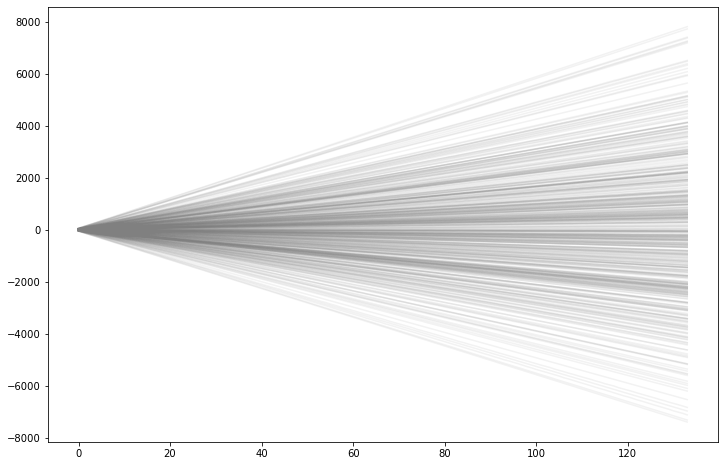

<IPython.core.display.Javascript object>

In [5]:
with model:
    prior_predictor = pm.sample_prior_predictive()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_predictor["y"].T, color="0.5", alpha=0.1)

plt.show()

This model can have a negative slope, which is impossible as the number of registered decks can never go down. So this is an extra contrain we can add in the next model. However, let's look at the fit anyway.

The latter could be corrected with a different prior for the slope e.g. ```slope = pm.HalfNormal("slope", sigma=3)``` or 
```python    
    BoundNormal_0 = pm.Bound(pm.Normal, lower = 0)
    slope = BoundNormal_0("slope", mu=0, sigma=20)
```

There also is a ```plot_trace()``` function which can give us a visual impression of the new values for the posteriors, priors updated after fitting the model, or the ```summary()``` function from Arviz that will show all posteriors' with their interval in tabular format.

<Figure size 504x504 with 0 Axes>

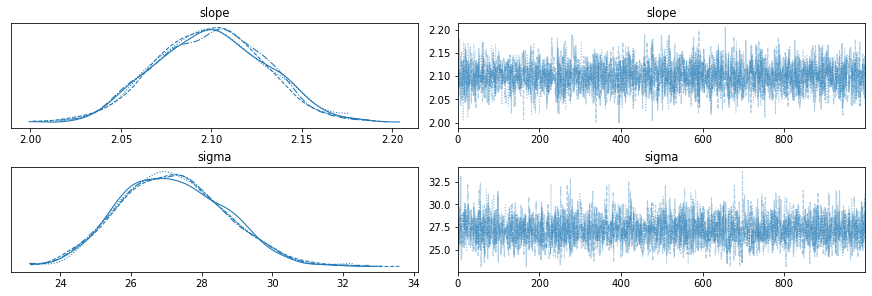

<IPython.core.display.Javascript object>

In [6]:
plt.figure(figsize=(7, 7))
pm.plot_trace(trace)
plt.show()

In [7]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.10,0.03,2.04,2.15,0.00,0.00,3203.62,2779.13,1.0
sigma,27.19,1.50,24.45,29.90,0.03,0.02,3422.80,2710.46,1.0


<IPython.core.display.Javascript object>

Despite having flaws, we were able to get a fit, lets have a look how well the model compares to the true data, using ```sample_posterior_predictive```

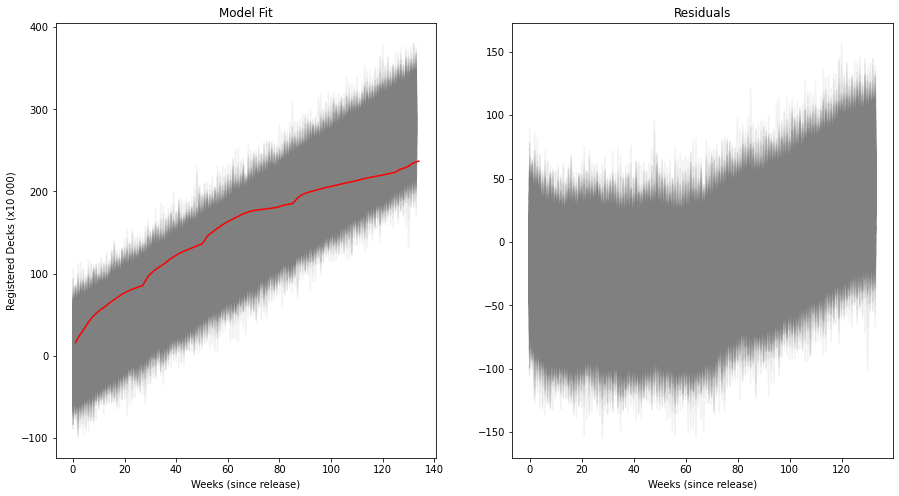

<IPython.core.display.Javascript object>

In [8]:
def plot_fit_residuals(m, t, df):
    with m:
        posterior_predictor = pm.sample_posterior_predictive(t)

    residuals = posterior_predictor["y"] - df["Total_scaled"].to_numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.plot(posterior_predictor["y"].T, color="0.5", alpha=0.1)
    ax1.plot(df.Total_scaled, color="red", alpha=1)
    ax1.set(
        xlabel="Weeks (since release)",
        ylabel="Registered Decks (x10 000)",
        title="Model Fit",
    )

    ax2.plot(residuals.T, color="0.5", alpha=0.1)
    ax2.set(xlabel="Weeks (since release)", title="Residuals")

    plt.show()


plot_fit_residuals(model, trace, model_data)

This last plot is already interesting! While the fit is not great, we can see in the Residuals plot that the error in the model is relatively stable until week 80 and then increases over time. This coinsides with the first lockdown due to COVID-19 and restrictions on gatherings. So there was no competitive play at all, picking up new decks would have been impossible for many due to stores being closed and for most buying new decks would have been futile as joining others to play was prohibited.

So based on this finding, when creating a better model, it would be best to fit the model on the first 80 weeks and use the posterior predictor on the full range. The deviation of the model with the real data could give hints on the impact of COVID-19 on KeyForge sales.

To include interactive graphs on [blog.4dcu.be](https://blog.4dcu.be) the charts need to be compatible with vega-lite. These can be made in python using Altair. So below is a function to do this. Check out details [here](http://blog.4dcu.be/programming/2021/05/03/Interactive-Visualizations.html) .

In [9]:
from pymc3_altair import plot_fit_altair

chart = plot_fit_altair(model, trace, model_data)

chart.properties(width="container").save("./altair_output/model_1.json")
chart

alt.LayerChart(...)

<IPython.core.display.Javascript object>

## Creating a better model

The linear model works and is good as a baseline, but the fit is rather poor. So we'll have to come up with something better.

  * No negative slope, the number of registered decks can never go down
  * Model the impact of new sets being released:
    * Interest in a set seems to peak upon release and then go down over time to almost zero as it gets harder and harder to find decks from that set.
    * Have a model with parameters for each set separately and the same --> could say something about the popularity
    * Build model on first 80 weeks only, use to evaluate effect of COVID-19 *or* use switch to have a pre-covid and post-covid rate
    * Might not be able to untangle popularity of Mass Mutation and Dark Tidings and COVID-19 effects

### Recreate linear model as generative model

First step is to recreate the linear model in such a way that we have a number of weekly sales and this is added to the previous number every step. This will allow for a more intuitive representation of other effects (like the COVID-19 impact). This type of model is called a generative model. 

For the implementation, especially the use of theano's ```scan()``` function, I heavily relied on Thomas Wiecki's PyMCon Presentation ([part 1](https://www.youtube.com/watch?v=ZxR3mw-Znzc) and [part 2](https://www.youtube.com/watch?v=_DCkJkMji0U)).

We'll start a second model, which is a simple re-implementation of the linear model as a generative model.

In [10]:
len_observed = len(model_data)

with pm.Model() as model_2:
    # priors
    sigma = pm.Exponential("sigma", lam=1.0)  # Sigma for likelihood function

    # We know from the previous analysis there are on average 15 000 decks registered per week
    # this can be the baseline (mu) with a rather large deviation (sigma)
    # as decks cannot be un-registered, this value can never go negative, so we'll put a limit on it preventing that
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    weekly_registrations = BoundNormal_0("weekly_registrations", mu=1.5, sigma=2)

    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(
        y0[0], 15
    )  # there were 150k decks registered the first week, that is the initial value (150 000/10 000)

    outputs, _ = theano.scan(
        fn=lambda t, y, ws: tt.set_subtensor(y[t], ws + y[t - 1]),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=weekly_registrations,
        n_steps=len_observed - 1,
    )

    total_registrations = pm.Deterministic("total_registrations", outputs[-1])

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=total_registrations, sigma=sigma, observed=model_data.Total_scaled
    )

    # posterior
    trace_2 = pm.sample(1000, cores=4, chains=4)

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\theano\gpuarray\dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weekly_registrations, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


<IPython.core.display.Javascript object>

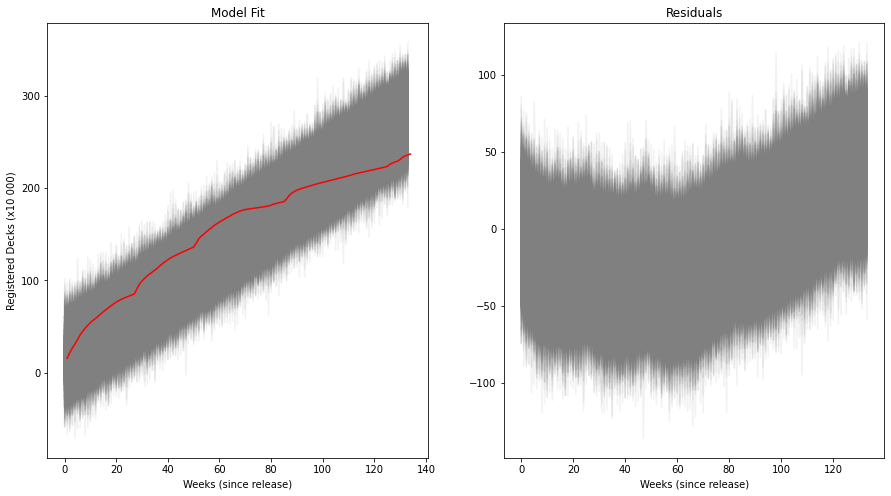

<IPython.core.display.Javascript object>

In [11]:
plot_fit_residuals(model_2, trace_2, model_data)

In [12]:
chart_2 = plot_fit_altair(model_2, trace_2, model_data)
chart_2.properties(width="container").save("./altair_output/model_2.json")
chart_2

alt.LayerChart(...)

<IPython.core.display.Javascript object>

As expected, this yields the same results as the first model, though now we have more options to add complexity! The next iterations will add new items to improve the model and better correspond reality.

### Adding a switch to account for COVID-19 impact

In this model a switch can be added where weekly sales during COVID-19 are different. We'll also have to specify when we think the pandemic started to impact sales in the model.


In [13]:
with pm.Model() as model_3:
    # priors
    sigma = pm.Exponential("sigma", lam=1.0)  # Sigma for likelihood function

    covid_start = pm.DiscreteUniform(
        "covid_start", lower=60, upper=85
    )  # COVID started at different points in different countries lets start around week 70

    # We know from the previous analysis there are on average 15 000 decks registered per week
    # this can be the baseline (mu) with a rather large deviation (sigma)
    # as decks cannot be un-registered, this value can never go negative, so we'll put a limit on it preventing that
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)

    # As the average is 15 000 (1.5 after scaling), and we assume COVID-19 had a negative impact on sales, we'll set the
    # initial value for post-COVID to 1 (10 000 decks registered per week)
    weekly_registrations_covid = BoundNormal_0(
        "weekly_registrations_covid", mu=1, sigma=2
    )

    # As the average was affected by COVID, pre-COVID sales were likely better, this is reflected by setting the intial value
    # of this prior to 2
    weekly_registrations_precovid = BoundNormal_0(
        "weekly_registrations_precovid", mu=2, sigma=2
    )

    weekly_registrations = pm.math.switch(
        covid_start >= model_data.Week_nr,
        weekly_registrations_precovid,
        weekly_registrations_covid,
    )

    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(
        y0[0], 15
    )  # there were 150k decks registered the first week, that is the initial value (15 after scaling)

    outputs, _ = theano.scan(
        fn=lambda t, y, ws: tt.set_subtensor(y[t], ws[t] + y[t - 1]),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=weekly_registrations,
        n_steps=len_observed - 1,
    )

    total_registrations = pm.Deterministic("total_registrations", outputs[-1])

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=total_registrations, sigma=sigma, observed=model_data.Total_scaled
    )

    # posterior
    trace_3 = pm.sample(1000, cores=10, chains=4)

Multiprocess sampling (4 chains in 10 jobs)
CompoundStep
>NUTS: [weekly_registrations_precovid, weekly_registrations_covid, sigma]
>Metropolis: [covid_start]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

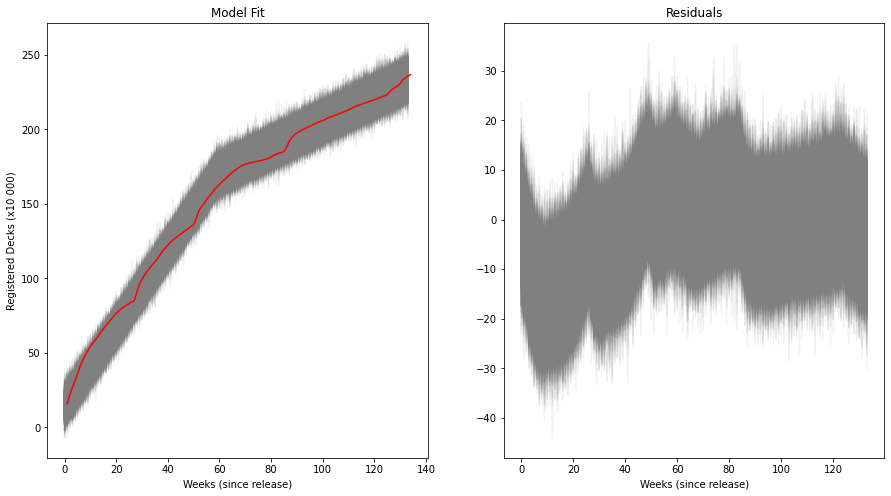

<IPython.core.display.Javascript object>

In [14]:
plot_fit_residuals(model_3, trace_3, model_data)

In [15]:
chart_3 = plot_fit_altair(model_3, trace_3, model_data)
chart_3.properties(width="container").save("./altair_output/model_3.json")
chart_3

alt.LayerChart(...)

<IPython.core.display.Javascript object>

In [16]:
with model_3:
    display(az.summary(trace_3, round_to=2))

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
covid_start,60.06,0.27,60.00,60.00,0.02,0.01,214.22,233.18,1.03
sigma,6.26,0.38,5.56,6.94,0.01,0.01,2290.93,2159.90,1.00
weekly_registrations_covid,0.86,0.03,0.81,0.91,0.00,0.00,1715.81,1710.36,1.00
weekly_registrations_precovid,2.62,0.02,2.58,2.65,0.00,0.00,1619.02,1631.11,1.00
total_registrations[0],15.00,0.00,15.00,15.00,0.00,0.00,4000.00,4000.00,NaN
...,...,...,...,...,...,...,...,...,...
total_registrations[129],230.03,1.27,227.76,232.47,0.02,0.02,2746.91,2946.34,1.00
total_registrations[130],230.89,1.30,228.44,233.23,0.02,0.02,2712.68,2938.11,1.00
total_registrations[131],231.75,1.32,229.28,234.15,0.03,0.02,2680.31,2938.52,1.00
total_registrations[132],232.62,1.35,230.10,235.07,0.03,0.02,2650.02,2892.39,1.00


<IPython.core.display.Javascript object>

The fit immediately improves a lot allowing the slope to change when lockdowns and social distancing was enforced in most contries, impairing sales. To confirm this model is better Arviz's ```compare()``` function is used, while here it is obvious, when models perform similarly this can be a great tool to ensure picking the best one.

In [17]:
az.compare({"linear": trace_2, "linear_covid_switch": trace_3})

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
linear_covid_switch,0,-438.933407,2.073602,0.000000,1.000000e+00,9.569336,0.000000,False,log
linear,1,-617.897111,1.500689,178.963704,8.364509e-11,4.704084,10.855222,False,log


<IPython.core.display.Javascript object>

Now that the impact of COVID-19 is captured by the model, more subtle variations that occurr around releases of new sets can be modelled. We know exactly when each set is released, so there is no need to put any uncertainty on that, however we do need to come up with a model for the impact of releasing a new set! Releases of sets are announced months prior to the actual release and in the weeks leading up to the product being available there are spoilers, teasers, ... creating quite a bit of initial hype. Once new decks appear in stores there seems to be an immediate rush to pick up some new decks, though that boost in sales is relatively short lived as interest deminishes over time.

That initial boost here is modelled by adding a number of extra deck registrations the week the product was released. This number will shrink with a decay factor next week, ... (similarly to the decay of radioactive elements). The pace at which interest decays we'll assume is constant, though the extra registrations a set can generate will depend on the set, cool new cards and/or mechanics will get more people to drop some money on new cards than sets with less interesting cards.

In [18]:
with pm.Model() as model_5:
    # priors
    sigma = pm.Exponential("sigma", lam=1.0)  # Sigma for likelihood function

    # COVID started at different points in different countries, it should be around week 70 give or take a week or two
    covid_start = pm.DiscreteUniform("covid_start", lower=68, upper=72)

    # We know from the previous that mu before and during covid should be around 0.8 and 3.0 respectively
    # Sigma is reduced here not to diverge to far from these values
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    weekly_registrations_covid = BoundNormal_0(
        "weekly_registrations_covid", mu=0.8, sigma=0.5
    )
    weekly_registrations_precovid = BoundNormal_0(
        "weekly_registrations_precovid", mu=3, sigma=0.5
    )

    weekly_registrations_base = pm.math.switch(
        covid_start >= model_data.Week_nr,
        weekly_registrations_precovid,
        weekly_registrations_covid,
    )

    # Model extra registrations due to shifting interest (like new sets being released)
    # The interest factor is calculated on a weekly basis
    decay_factor = pm.Exponential("decay_factor", lam=1.0)

    cota_interest = pm.HalfNormal("cota_interest", sigma=2)
    aoa_interest = pm.HalfNormal("aoa_interest", sigma=2)
    wc_interest = pm.HalfNormal("wc_interest", sigma=2)
    mm_interest = pm.HalfNormal("mm_interest", sigma=2)
    dt_interest = pm.HalfNormal("dt_interest", sigma=2)

    # Another way of defining interest is in extra registrations caused (not as a factor)
    cota_surplus = pm.Deterministic(
        "cota_surplus", cota_interest * weekly_registrations_base[0]
    )
    aoa_surplus = pm.Deterministic(
        "aoa_surplus", aoa_interest * weekly_registrations_base[27]
    )
    wc_surplus = pm.Deterministic(
        "wc_surplus", wc_interest * weekly_registrations_base[50]
    )
    mm_surplus = pm.Deterministic(
        "mm_surplus", mm_interest * weekly_registrations_base[85]
    )
    dt_surplus = pm.Deterministic(
        "dt_surplus", dt_interest * weekly_registrations_base[126]
    )

    interest_decayed = [cota_interest]

    for i in range(len_observed - 1):
        new_element = interest_decayed[i] * decay_factor
        if i == 27:
            new_element += aoa_interest
        if i == 50:
            new_element += wc_interest
        if i == 85:
            new_element += mm_interest
        if i == 126:
            new_element += dt_interest
        interest_decayed.append(new_element)

    # there were 150k decks registered the first week, that is the initial value
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], 15)

    outputs, _ = theano.scan(
        fn=lambda t, y, ws, intfac: tt.set_subtensor(
            y[t], (ws[t] * (1 + intfac[t])) + y[t - 1]
        ),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=[weekly_registrations_base, interest_decayed],
        n_steps=len_observed - 1,
    )

    total_registrations = pm.Deterministic("total_registrations", outputs[-1])

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=total_registrations, sigma=sigma, observed=model_data.Total_scaled
    )

    # posterior
    trace_5 = pm.sample(1000, cores=10, chains=4)

Multiprocess sampling (4 chains in 10 jobs)
CompoundStep
>NUTS: [dt_interest, mm_interest, wc_interest, aoa_interest, cota_interest, decay_factor, weekly_registrations_precovid, weekly_registrations_covid, sigma]
>Metropolis: [covid_start]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1298 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 375 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

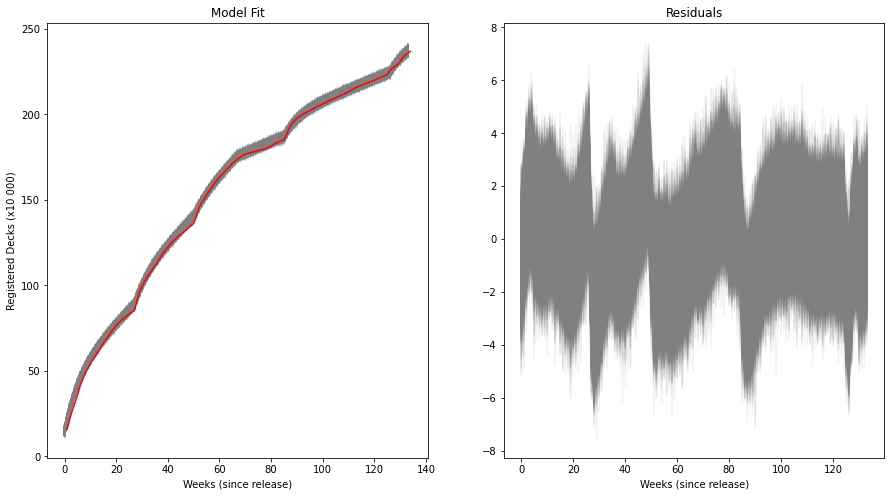

<IPython.core.display.Javascript object>

In [19]:
plot_fit_residuals(model_5, trace_5, model_data)

In [20]:
chart_5 = plot_fit_altair(model_5, trace_5, model_data)
chart_5.properties(width="container").save("./altair_output/model_5.json")
chart_5

alt.LayerChart(...)

<IPython.core.display.Javascript object>

In [21]:
az.compare(
    {
        "linear": trace_2,
        "linear_covid_switch": trace_3,
        "linear_covid_switch_interest_factor_good": trace_5,
    }
)

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
linear_covid_switch_interest_factor_good,0,-215.029196,8.424408,0.000000,1.000000e+00,8.039313,0.000000,False,log
linear_covid_switch,1,-438.933407,2.073602,223.904211,3.244498e-12,9.569336,12.887120,False,log
linear,2,-617.897111,1.500689,402.867915,0.000000e+00,4.704084,9.574523,False,log


<IPython.core.display.Javascript object>

This greatly improves the fit of the model again! So including interest in a set this way seems to be a good model for KeyForge as well. Using the model summary, we can actually check the interest in each set and potentially say something about the reception of these sets.

In [22]:
with model_5:
    stats = pd.DataFrame(az.summary(trace_5, round_to=2))

stats.loc[
    [
        "sigma",
        "covid_start",
        "weekly_registrations_covid",
        "weekly_registrations_precovid",
        "cota_interest",
        "aoa_interest",
        "wc_interest",
        "mm_interest",
        "dt_interest",
        "decay_factor",
        "cota_surplus",
        "aoa_surplus",
        "wc_surplus",
        "mm_surplus",
        "dt_surplus",
    ]
]

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.17,0.07,1.04,1.30,0.00,0.00,354.50,1420.02,1.02
covid_start,68.00,0.00,68.00,68.00,0.00,0.00,4000.00,4000.00,NaN
weekly_registrations_covid,0.62,0.02,0.59,0.66,0.00,0.00,748.58,425.34,1.00
weekly_registrations_precovid,1.55,0.06,1.44,1.66,0.00,0.00,477.68,859.12,1.02
cota_interest,4.10,0.19,3.76,4.48,0.01,0.00,1135.77,1891.67,1.00
aoa_interest,1.69,0.16,1.42,2.01,0.01,0.00,902.16,1161.44,1.01
wc_interest,0.94,0.14,0.69,1.20,0.00,0.00,809.41,928.24,1.01
mm_interest,3.21,0.32,2.61,3.82,0.01,0.01,509.95,368.48,1.02
dt_interest,3.05,0.35,2.39,3.69,0.01,0.01,1135.77,2001.47,1.01
decay_factor,0.83,0.01,0.82,0.85,0.00,0.00,606.70,1135.31,1.02


<IPython.core.display.Javascript object>

The first set Call of the Archons (CotA) generated a lot of interest and a 414% surplus registrations the first week was seen over what you would expect with a linear model. The next sets released pre-COVID, Age of Ascension (AoA) somewhat surpringly outperformed Worlds Collide (WC), despite often being referred ot as the weaker set with uninspired mechanics (alpha, omega, deploy). 

Mass Mutation and Dark Tidings seem to perform considerably better, though as these were released during COVID, and baseline sales where much lower during that period, this is hard to compare with previous sets.

## Conclusion

This was my first attempt at using a Bayesian model, though by going through this exercise it is clear that where possible this offers some advantages. It is much more transparant and easily interpretable than e.g. a machine learning model. Being able to change paramters in the model and forecasting the effects some very cool things can be achieved (like simulating numbers in the absense of a global pandemic) with little effort. However, it does require a deeper understanding of the problem at hand (like how to model interest after marketing and releasing a new set and the decay). While not necessarily a bad thing, this would make it harder to apply in a meaning full way on data where signals are more cryptic and effects poorly understood.

There is also no way to deny COVID 19 has greatly impacted the lives and likelyhoods of many individuals and compagnies alike. KeyForge deck registrations (base rate) has dropped to roughly 40% of the pre-COVID rate. Despite the two most recent sets doing very well, over the last 18 months or so the number of deck registrations is far below the expected rate. 

With restrictions being lifted however it will be cool to see how KeyForge continues post COVID. To make a meaningful statement we'll have to keep tracking the number of registered decks for at least another 18 months or so though ... it will be intersting to see but don't hold you breath.